# **1. 전이 학습(Transfer Learning)**

* 하나의 작업을 위해서 훈련된 모델을 유사 작업 수행 모델의 시작점으로 활용할 수 있는 딥러닝 접근법
* 신경망은 처음부터 새로 학습하는 것보다 전이 학습을 통해 업데이트하고 재학습하는 편이 더 빠르고 간편함
* 전이 학습은 여러 응용분야(검출, 영상인식, 음성인식, 자연어처리, 검색분야..)에서 많이 사용됨

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

# **2. 케글 데이터 셋**

* [케글](https://www.kaggle.com/)에 로그인
* 우측 상단 클릭 -> your profile -> settings -> 하단의 account에서 하단 api create new api token 클릭 -> Kaggle.json 파일이 다운로드 됨
* Kaggle.json 파일을 메모장으로 열기
    * {"username":"nugler","key":"bbb4be71083a4ad8227bebddc1fc213d"}

In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

# **3. 에일리언 VS 프레데터 데이터 셋**

* [데이터셋](https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images)

In [3]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

Dataset URL: https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
License(s): ODbL-1.0
alien-vs-predator-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip -q /content/alien-vs-predator-images.zip

# **4. 이미지 증강 기법 (image Augmentation)**

* 원본 이미지(데이터)를 조작하여 원본과는 크고 작은 변화를 가진 이미지를 생성하여 학습하는 기법
* 일반적으로 모델 성능이 좋아짐
* 오버피팅을 방지하는 목적
* [이미지 증강기법](https://pytorch.org/vision/master/transforms.html)

In [5]:
from os.path import abspath
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [6]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224, 224)),
        # 각도, 크기 변경, 찌그러뜨림
        transforms.RandomAffine(degrees = 30, scale = (0.8, 1.2), shear = 10),
        # 수평으로 뒤집기
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [7]:
def target_transforms(target) :
    return torch.FloatTensor([target])

In [8]:
image_datasets = {
    'train' : datasets.ImageFolder('data/train', data_transforms['train'], target_transform = target_transforms),
    'validation' : datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform = target_transforms)
}

In [9]:
dataloaders = {
    'train' : DataLoader(
        image_datasets['train'],
        batch_size = 32,
        shuffle = True
    ),
    'validation' : DataLoader(
        image_datasets['validation'],
        batch_size = 32,
        shuffle = False
    )
}

In [10]:
len(image_datasets['train']), len(image_datasets['validation'])

(694, 200)

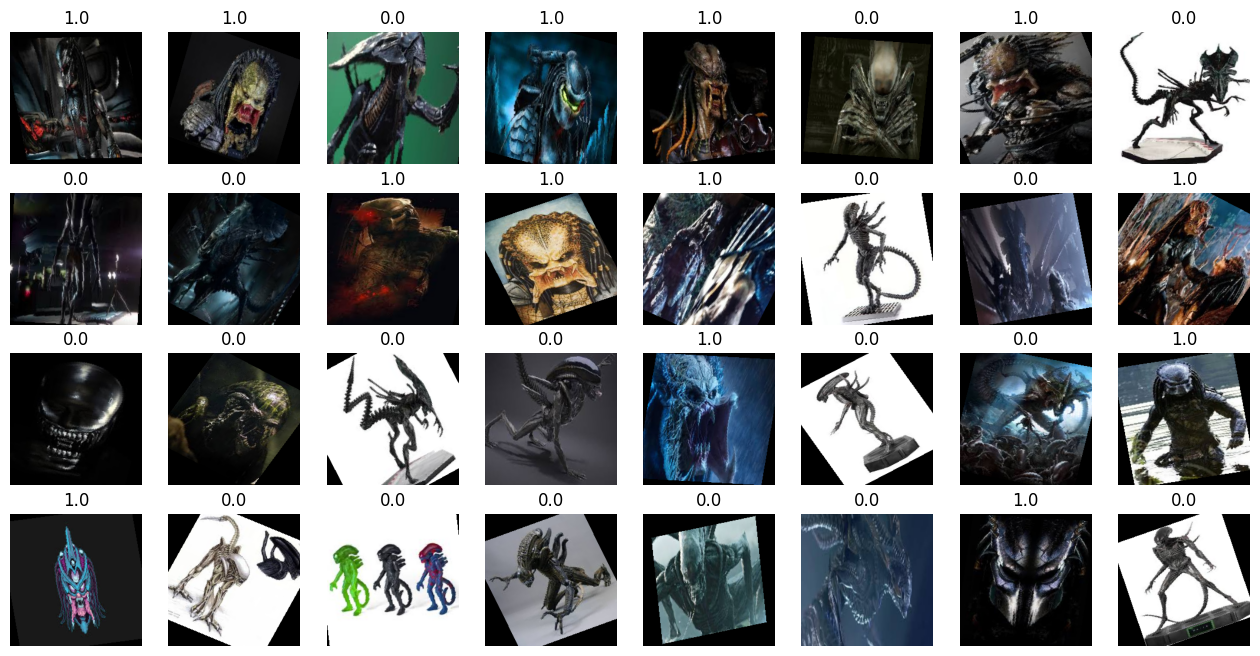

In [11]:
imgs, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0)) # (3, 224, 224) ->(224, 224, 3)
    ax.set_title(label.item())
    ax.axis('off')

# **5. 사전 학습된 ResNet50 모델**

* [파이토치에서 제공하는 사전학습 모델들](https://pytorch.org/vision/stable/models.html)

![](https://i.stack.imgur.com/gI4zT.png)

### 5-1. ResNet50 특징

* 50개의 layer로 구성되어 있으며 주로 convolution layer와 batch nomalization, ReLU 활성화 함수, 풀링 레이어 등으로 이루어져 있음
* 기울기 소실 문제를 해결하고 훨씬 더 깊은 네트워크를 효과적으로 학습시킬 수 있음
* 이미지 분류, 객체 탐지 등 다양한 컴퓨터 비전 작업에서 높은 성능을 보임

### 5-2. 이미지넷(ImageNet)

* 이미지 데이터 베이스
* 1000개의 클래스로 동물과 사물 이미지 포함

![](https://i.imgur.com/5Rz5s8e.png)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
model = models.resnet50(weights = 'IMAGENET1K_V1').to(device)

In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 5-3. Freeze Layers

* 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들ㅇ느 수정하지 않도록 설정
* 출력 부분의 레이어(FC)를 다시 설정하여 분류에 맞게 변경

In [15]:
for param in model.parameters() :
    param.requires_grad = False # 가져온 파라미터를 업데이트 하지 않음

In [16]:
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

In [19]:
epochs = 10

for epoch in range(epochs) :

    for phase in ['train', 'validation'] :

        if phase == 'train' :
            model.train()

        else :
            model.eval()

        sum_losses = 0
        sum_acc = 0

        for x_batch, y_batch in dataloaders[phase] :
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train' :
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_acc = sum_acc + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_acc / len(dataloaders[phase])

        print(f'{phase:10s} : Epoch {epoch + 1:4d} / {epochs} Loss : {avg_loss : .4f} Accuracy : {avg_acc : .2f}%')



train      : Epoch    1 / 10 Loss :  0.6257 Accuracy :  67.06%
validation : Epoch    1 / 10 Loss :  0.4572 Accuracy :  90.18%
train      : Epoch    2 / 10 Loss :  0.4060 Accuracy :  84.67%
validation : Epoch    2 / 10 Loss :  0.3292 Accuracy :  90.18%
train      : Epoch    3 / 10 Loss :  0.3102 Accuracy :  87.76%
validation : Epoch    3 / 10 Loss :  0.2644 Accuracy :  92.41%
train      : Epoch    4 / 10 Loss :  0.2846 Accuracy :  87.58%
validation : Epoch    4 / 10 Loss :  0.2408 Accuracy :  90.63%
train      : Epoch    5 / 10 Loss :  0.2178 Accuracy :  92.28%
validation : Epoch    5 / 10 Loss :  0.2265 Accuracy :  92.86%
train      : Epoch    6 / 10 Loss :  0.2241 Accuracy :  90.56%
validation : Epoch    6 / 10 Loss :  0.2135 Accuracy :  92.86%
train      : Epoch    7 / 10 Loss :  0.2280 Accuracy :  90.34%
validation : Epoch    7 / 10 Loss :  0.2433 Accuracy :  89.73%
train      : Epoch    8 / 10 Loss :  0.1908 Accuracy :  93.90%
validation : Epoch    8 / 10 Loss :  0.2072 Accuracy : 

In [20]:
from PIL import Image

In [22]:
img1 = Image.open('/content/data/train/alien/22.jpg')
img2 = Image.open('/content/data/validation/predator/21.jpg')

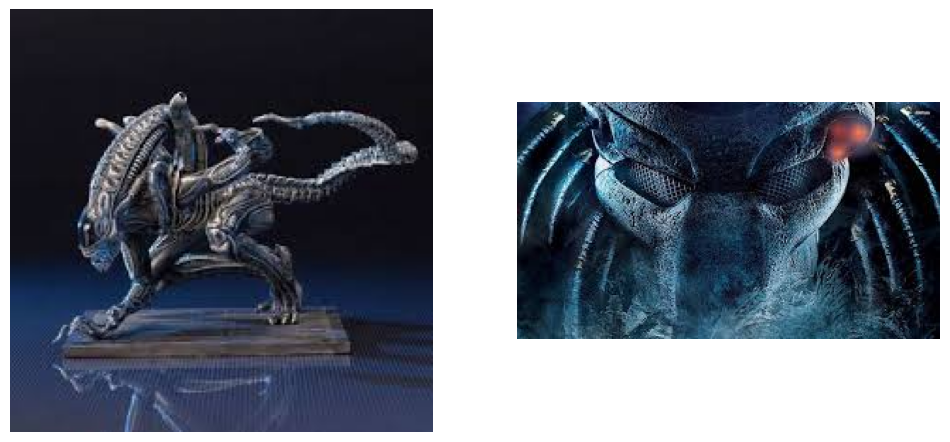

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()










In [24]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [25]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)

test_batch.shape

torch.Size([2, 3, 224, 224])

In [26]:
y_pred = model(test_batch)

y_pred

tensor([[3.3810e-05],
        [9.8378e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)

(-0.5, 298.5, 167.5, -0.5)

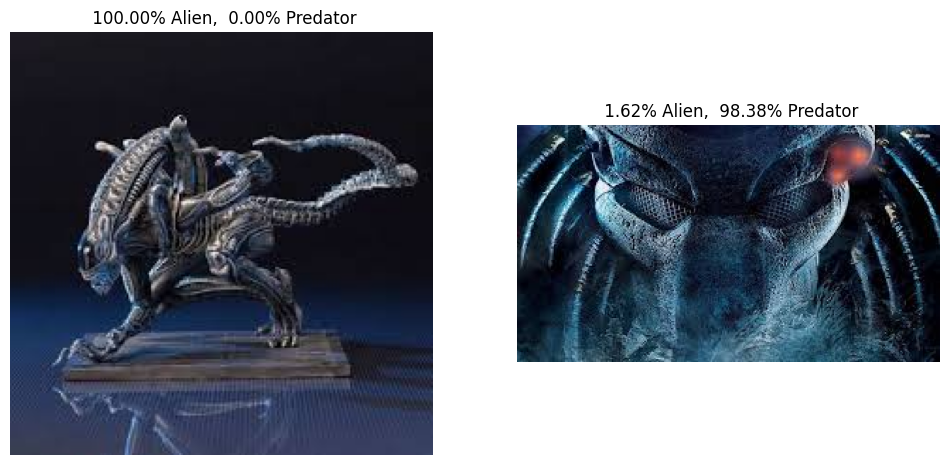

In [28]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

axes[0].set_title(f'{(1-y_pred[0, 0]) * 100 : .2f}% Alien, {(y_pred[0, 0]) * 100 : .2f}% Predator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0]) * 100 : .2f}% Alien, {(y_pred[1, 0]) * 100 : .2f}% Predator')
axes[1].imshow(img2)
axes[1].axis('off')